<a href="https://colab.research.google.com/github/pratham-aggr/ds3_solana/blob/main/src/ds3_solana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning

In [ ]:
!pip install rapidfuzz
!pip install python-Levenshtein
!pip install fuzzy

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!git clone https://github.com/pratham-aggr/ds3_solana.git

fatal: destination path 'ds3_solana' already exists and is not an empty directory.


In [ ]:
all_data = pd.read_csv('/content/ds3_solana/assets/all_data.csv')

In [ ]:
#creating a deep copy so that changes in df will not affect changes in all_data
df = all_data.copy(deep=True)

In [ ]:
#Renaming cols
#entering pp_num is optional
df.columns = ['notes1', 'timestamp', 'last_name', 'pp_num', 'num_buckets1', 'more_bb_needed', 'bucket1_weight', 'bucket2_weight', 'notes2', 'num_buckets2']

In [ ]:
#Shifting cols
col_subset = np.array(df.columns[1:-2])  # Selecting relevant columns
extra_cols = np.array(['num_buckets2', 'notes1', 'notes2'])
new_cols = np.concatenate((col_subset, extra_cols))
df = df[new_cols]

In [ ]:
df['more_bb_needed'].unique()

array(['No', 'Yes', nan, 'no', 'dropped'], dtype=object)

In [ ]:
# yes: 1, no: 0, other: as is (etc 'dropped')
df['more_bb_needed'] = df['more_bb_needed'].str.lower().apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

In [ ]:
df['more_bb_needed'].unique()

array([0, 1, nan, 'dropped'], dtype=object)

In [ ]:
# ensuring uniformity in last_name
df['last_name'] = df['last_name'].str.title()
df['last_name'] = df['last_name'].str.strip()
df['pp_num'] = df['pp_num'].fillna('empty')
df['pp_num'] = df['pp_num'].apply(lambda x: x.lstrip('0') if x.lstrip('0') != "" else x)

In [ ]:
df['timestamp'] = df['timestamp'].astype(str)

In [ ]:
typical_timestamp = 'mm/dd/yyyy hh:mm:ss'
#df[df['timestamp'].str.len() == len(typical_timestamp)]

In [ ]:
#checking whether 'bucket2_weight' is empty or not
assert df[df['bucket2_weight'].notna()].shape[0] == 0
#Yes it is prolly drop the col then!
df.drop('bucket2_weight', axis=1, inplace=True)

In [ ]:
# some rows are empty let's drop them
#df[2382:]
#but there are various types of nans so we will be making them same
df.replace([None, 'nan', 'NaN', np.nan], np.nan, inplace=True)
#dropping empty rows between the data
df = df.dropna(how='all')
#re ordering the indx
df = df.reset_index(drop=True)

In [ ]:
df = df[:2882] #removing the last rows which have some summaries

In [ ]:
# nans in last_name replaced with 'Anonymous'
df['last_name'] = df['last_name'].fillna('Anonymous')

In [ ]:
# # for 'No Name' we don't have pp_num right? pretty obvious but still checking
# assert (df[df['last_name'] == 'No Name'].shape[0] == df[(df['last_name'] == 'No Name') & (df['pp_num'].isna())].shape[0]) == True
# #hence we can replace 'No Name' with 'Anonymous'

In [ ]:
df['last_name'] = df['last_name'].apply(lambda x: x.replace('No Name', 'Anonymous'))

In [ ]:
df[df["timestamp"] == "3/18/2021 16:58:44"]
#index 2759

,timestamp,last_name,pp_num,num_buckets1,more_bb_needed,bucket1_weight,num_buckets2,notes1,notes2
2858,3/18/2021 16:58:44,Marks,31,2,1,16,2,NaN,NaN


In [ ]:
single_date = len("3/8/2021 16:58:44")
ideal_len2 = len("03/08/2021 16:58:44")

In [ ]:
"03/08/2021 16:58:44".split()[0]

'03/08/2021'

In [ ]:
df.tail(5)

,timestamp,last_name,pp_num,num_buckets1,more_bb_needed,bucket1_weight,num_buckets2,notes1,notes2
2877,7/4 + 7/11,Anonymous,empty,NaN,NaN,34.9,1,NaN,NaN
2878,7/4 + 7/11,Anonymous,empty,NaN,NaN,21.6,1,NaN,NaN
2879,7/4 + 7/11,Anonymous,empty,NaN,NaN,25.2,1,NaN,NaN
2880,7/4 + 7/11,Anonymous,empty,NaN,NaN,25.7,1,NaN,NaN
2881,7/4 + 7/11,Anonymous,empty,NaN,NaN,14.7,1,NaN,NaN


In [ ]:
#fill NaN with "empty"
df['timestamp_adj']= df['timestamp'].fillna("00/00/0000")

In [ ]:
#verify no missing
df['timestamp_adj'].isna().sum()

np.int64(0)

In [ ]:
adj_time_col = df['timestamp_adj'].apply(lambda x: x.split()[0])
#for values structured like "7/30 + 8/1" the first of the two dates is kept
new_df = df.assign(adj_time_col=adj_time_col)

In [ ]:
def extract_month(input_time):
  #with format M/D/Y

  return input_time.split("/")[0]

def extract_day(input_time):
  return input_time.split("/")[1]

def extract_year(input_time):
  lst = input_time.split("/")
  if len(lst)> 2:
    return lst[-1]
  else:
    return "0000"

In [ ]:
"4/21".split("/")[1]

'21'

In [ ]:
month = new_df['adj_time_col'].apply(extract_month)
day = new_df['adj_time_col'].apply(extract_day)
year = new_df['adj_time_col'].apply(extract_year)
new_df = new_df.assign(month=month)
new_df = new_df.assign(day=day)
new_df = new_df.assign(year=year)
new_df

,timestamp,last_name,pp_num,num_buckets1,more_bb_needed,bucket1_weight,num_buckets2,notes1,notes2,timestamp_adj,adj_time_col,month,day,year
0,3/12/2020 11:53:06,Roth-Heater,47,1,0,21.2,1,NaN,NaN,3/12/2020 11:53:06,3/12/2020,3,12,2020
1,3/12/2020 11:22:33,Evans,112,1,1,25.9,1,NaN,NaN,3/12/2020 11:22:33,3/12/2020,3,12,2020
2,3/12/2020 11:07:59,Bourgeot,147,1,0,39.4,1,NaN,NaN,3/12/2020 11:07:59,3/12/2020,3,12,2020
3,3/12/2020 10:16:30,Grauer,152,1,1,30,1,NaN,NaN,3/12/2020 10:16:30,3/12/2020,3,12,2020
4,3/12/2020 9:29:43,Ruiz,54,1,0,31,1,NaN,NaN,3/12/2020 9:29:43,3/12/2020,3,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,7/4 + 7/11,Anonymous,empty,NaN,NaN,34.9,1,NaN,NaN,7/4 + 7/11,7/4,7,4,0000
2878,7/4 + 7/11,Anonymous,empty,NaN,NaN,21.6,1,NaN,NaN,7/4 + 7/11,7/4,7,4,0000
2879,7/4 + 7/11,Anonymous,empty,NaN,NaN,25.2,1,NaN,NaN,7/4 + 7/11,7/4,7,4,0000
2880,7/4 + 7/11,Anonymous,empty,NaN,NaN,25.7,1,NaN,NaN,7/4 + 7/11,7/4,7,4,0000


In [ ]:
new_df['year'].replace({'18': '2018', '0000': '2018', '19': '2019', '20': '2020'}, inplace=True)


<ipython-input-127-0cfa75dc4283>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['year'].replace({'18': '2018', '0000': '2018', '19': '2019', '20': '2020'}, inplace=True)


In [ ]:
print(list(new_df['day'].unique()))
print(list(new_df['month'].unique()))
print(list(new_df['year'].unique()))

['12', '11', '10', '7', '5', '3', '2', '29', '27', '25', '22', '20', '18', '15', '14', '13', '8', '6', '4', '1', '31', '30', '28', '23', '21', '16', '9', '26', '24', '19', '17', '00']
['3', '2', '1', '12', '11', '10', '9', '8', '7', '6', '5', '4', '00']
['2020', '2019', '2018', '2021']


In [ ]:
new_df['month'].iloc[1419] = '2'
new_df['month'].iloc[1420] = '2'
new_df['day'].iloc[1419] = '26'
new_df['day'].iloc[1420] = '26'
new_df['month'].iloc[1421] = '4'
new_df['day'].iloc[1421] = '17'

<ipython-input-129-6b0d87518095>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_df['month'].iloc[1419] = '2'
<ipython-input-129-6b0d87518095>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are settin

In [ ]:
my_df = new_df.copy(deep=True)

In [ ]:
# Group by pp_num and aggregate names
duplicates = my_df.groupby('pp_num')['last_name'].agg(list)

# Filter only those pp_nums that have more than one associated name
duplicates = duplicates[duplicates.apply(len) > 1]

# Update names only when 'empty' is not in the list
duplicates = duplicates.apply(lambda x: [name for name in x if name != 'empty'] if 'empty' not in x else x)

# Convert to DataFrame if needed
result_df = duplicates.reset_index().rename(columns={'last_name': 'names'})


In [ ]:
result_df

,pp_num,names
0,0,"[Gherard, Returned-Dmfair, No Label By Staff]"
1,00,"[Non-Participant, Weinstein, Maranda, Gaylord]"
2,1,"[Dmv, Dmv, Dmv, Dmv, `Dmv, Dmv, Dmv, Dmv, Dmv,..."
3,100,"[Braunstein, Braunstein, Braunstein, Marley, B..."
4,101,"[Martinii, Martini, Martini, Martini, Martini,..."
...,...,...
179,95,"[Rohrbaugh, Rohrbaugh, Rohrbaugh, Rohrbaugh, R..."
180,96,"[Maranda, Maranda, Maranda, Maranda, Maranda]"
181,98,"[Bohannan, Bohannan, Bohannan]"
182,99,"[Melzer, Melzer, Melzer, Melzer, Melzer, Melze..."


In [ ]:
result_df = result_df.assign(correct_last_name = result_df['names'].apply(lambda x: x[0]))
result_df = result_df[['pp_num', 'correct_last_name']]

In [ ]:
result_df

,pp_num,correct_last_name
0,0,Gherard
1,00,Non-Participant
2,1,Dmv
3,100,Braunstein
4,101,Martinii
...,...,...
179,95,Rohrbaugh
180,96,Maranda
181,98,Bohannan
182,99,Melzer


In [ ]:
my_df = my_df.merge(result_df, on='pp_num', how='left')

In [ ]:
# num_buckets2 is nan and num_buckets1 is not nan? -> No
# my_df[my_df['num_buckets2'].isna() & my_df['num_buckets1'].notna()]

In [ ]:
my_df.at[1674, 'num_buckets2'] = 2.5
my_df[my_df['num_buckets1'].notna() & my_df['num_buckets1'].notna() & (my_df['num_buckets1'] != my_df['num_buckets2'])]

,timestamp,last_name,pp_num,num_buckets1,more_bb_needed,bucket1_weight,num_buckets2,notes1,notes2,timestamp_adj,adj_time_col,month,day,year,correct_last_name
1494,4/25/2020 11:47:04,Beach,196,1 bucket #310 4/25/20 11:45am,0,28.3,1,NaN,NaN,4/25/2020 11:47:04,4/25/2020,4,25,2020,NaN
1496,4/25/2020 12:16:53,Lakin,53,2 + about 2 of my own,0,28.3,4,NaN,NaN,4/25/2020 12:16:53,4/25/2020,4,25,2020,Lakin
1507,4/30/2020 15:27:20,Kisling,empty,"Dropped off 2 (we made a new bucket), picking ...",0,27,1,NaN,NaN,4/30/2020 15:27:20,4/30/2020,4,30,2020,Senior Center
1674,6/13/2020 13:43:14,Lakin,53,2 and about 1/2 a bucket extra,0,NaN,2.5,NaN,NaN,6/13/2020 13:43:14,6/13/2020,6,13,2020,Lakin
1995,10/3/2020 11:12:26,"Oh, Monica",236,"brought from home, trash bucket.",0,18.7,1,NaN,NaN,10/3/2020 11:12:26,10/3/2020,10,3,2020,"Oh, Monica"
2026,10/10/2020 11:27:26,"Ingram, Gerry",64,"(every other month, confirmed)",0,25,1,NaN,NaN,10/10/2020 11:27:26,10/10/2020,10,10,2020,Ingram
2098,10/29/2020 12:35:21,Roy,135,"Dropped off two buckets, will stay with one bu...",0,25,1,NaN,NaN,10/29/2020 12:35:21,10/29/2020,10,29,2020,Roy


In [ ]:
my_df = my_df.drop('num_buckets1', axis=1)
my_df.rename(columns={'num_buckets2': 'num_buckets', 'bucket1_weight': 'bucket_weight'}, inplace=True)
my_df = my_df[['pp_num', 'month', 'day', 'year', 'last_name', 'correct_last_name', 'num_buckets', 'more_bb_needed', 'bucket_weight']]

In [ ]:
my_df[my_df['pp_num'] == 'empty']

,pp_num,month,day,year,last_name,correct_last_name,num_buckets,more_bb_needed,bucket_weight
151,empty,2,6,2020,Senior Center,Senior Center,6,NaN,NaN
164,empty,2,4,2020,City Hall,Senior Center,8,NaN,NaN
871,empty,5,14,2019,Josepho,Senior Center,1,NaN,NaN
1421,empty,4,17,2018,Anonymous,Senior Center,NaN,NaN,NaN
1436,empty,3,17,2020,Brown,Senior Center,1,0,30
...,...,...,...,...,...,...,...,...,...
2877,empty,7,4,2018,Anonymous,Senior Center,1,NaN,34.9
2878,empty,7,4,2018,Anonymous,Senior Center,1,NaN,21.6
2879,empty,7,4,2018,Anonymous,Senior Center,1,NaN,25.2
2880,empty,7,4,2018,Anonymous,Senior Center,1,NaN,25.7


In [ ]:
my_df['correct_last_name'] = my_df.apply(
    lambda row: row['last_name'] if row['pp_num'] == 'empty' or row['pp_num'] == '' else row['correct_last_name'],
    axis=1
)

In [ ]:
my_df['more_bb_needed'] = my_df['more_bb_needed'].replace('dropped', np.nan)
my_df['more_bb_needed'] = my_df['more_bb_needed'].astype(float)

<ipython-input-141-4b3fda16fca2>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['more_bb_needed'] = my_df['more_bb_needed'].replace('dropped', np.nan)


In [ ]:
my_df[['month', 'day', 'year']] = my_df[['month', 'day', 'year']].astype(int)

# Analysis

In [ ]:
import re
def clean_weight(val):
   if pd.isna(val):
       return np.nan
   val = str(val).strip().lower()


   # Replace known invalid values
   if val in ['dropped out', 'nk', 'new']:
       return np.nan


   # Handle values like '23+18' or '29 & 33'
   if '+' in val or '&' in val:
       numbers = re.findall(r'\d+\.?\d*', val)
       if numbers:
           return sum(float(num) for num in numbers)


   # Handle standard numeric values
   try:
       return float(val)
   except ValueError:
       return np.nan


# Apply cleaning
my_df['bucket_weight'] = my_df['bucket_weight'].apply(clean_weight)


# No need to convert to Int64 — keep as float
assert my_df['bucket_weight'].dtype == float

In [ ]:
# Check for any zero values in day or month
invalid_rows = my_df[(my_df['day'] == 0) | (my_df['month'] == 0)]
invalid_rows
# problem is we don't have day/month info in data

,pp_num,month,day,year,last_name,correct_last_name,num_buckets,more_bb_needed,bucket_weight
1418,0,0,0,2018,No Label By Staff,Gherard,NaN,NaN,NaN
2381,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2382,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2383,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2384,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2475,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2476,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2477,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN
2478,empty,0,0,2018,Anonymous,Anonymous,NaN,NaN,NaN


In [ ]:
my_df_valid = my_df[(my_df['day'] != 0) & (my_df['month'] != 0)]
my_df_valid['date'] = pd.to_datetime(my_df_valid[['year', 'month', 'day']])


<ipython-input-145-841456023b05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df_valid['date'] = pd.to_datetime(my_df_valid[['year', 'month', 'day']])


In [ ]:
my_df[['month', 'day']] = my_df[['month', 'day']].replace(0, pd.NA)
my_df['date'] = pd.to_datetime(my_df[['year', 'month', 'day']], errors='coerce')


In [ ]:
my_df['date'] = pd.to_datetime(my_df[['year', 'month', 'day']])

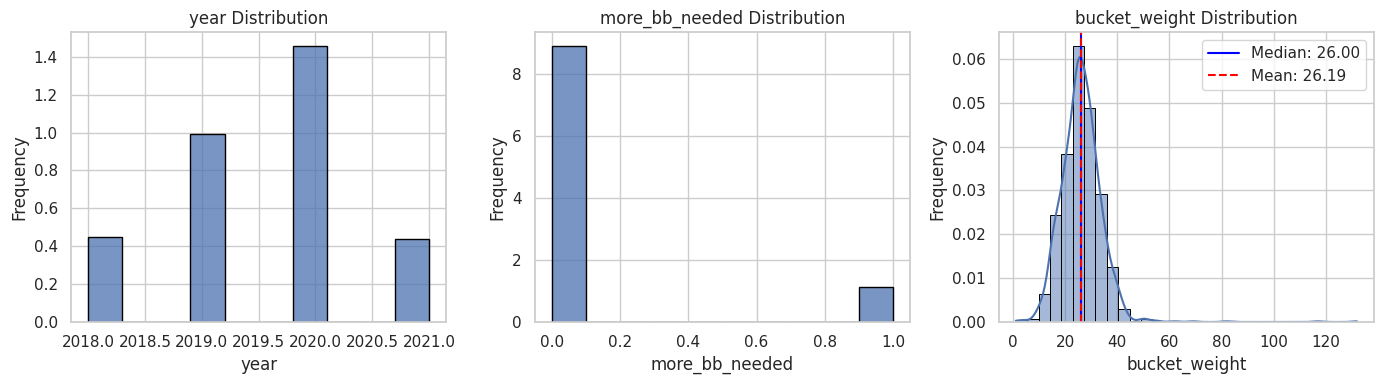

In [ ]:
sns.set(style="whitegrid")

# Create subplots: One for each numeric column in my_df
num_cols = my_df.select_dtypes(include='number').columns
n_cols = 3  # Number of columns of subplots
n_rows = (len(num_cols) // n_cols) + (len(num_cols) % n_cols)

plt.figure(figsize=(14, 4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    if i == 2:
      sns.histplot(my_df[col], bins=30, kde=True, edgecolor='black', stat = 'density')

      mean_val = my_df[col].mean()
      median_val = my_df[col].median()

      plt.axvline(median_val, color='blue', linestyle='-', label=f'Median: {median_val:.2f}')
      plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')

      plt.legend()

    else:
      sns.histplot(my_df[col], bins=10, edgecolor='black',  stat = 'density')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
my_df['month'].unique()

array([3, 2, 1, 12, 11, 10, 9, 8, 7, 6, 5, 4, <NA>], dtype=object)

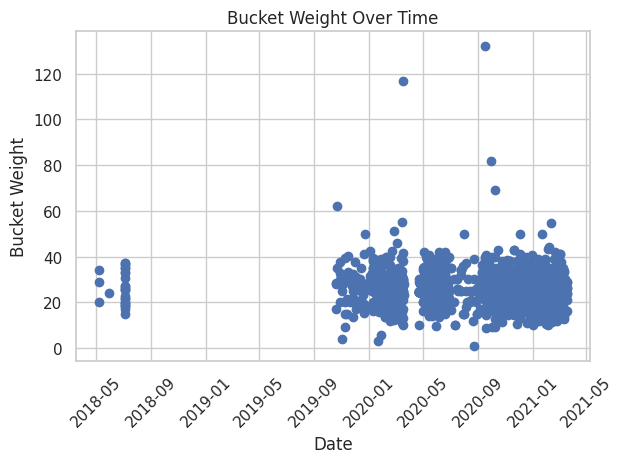

In [ ]:
plt.scatter(my_df['date'], my_df['bucket_weight'])
plt.title('Bucket Weight Over Time')
plt.xlabel('Date')
plt.ylabel('Bucket Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
my_df

,pp_num,month,day,year,last_name,correct_last_name,num_buckets,more_bb_needed,bucket_weight,date
0,47,3,12,2020,Roth-Heater,Roth-Heater,1,0.0,21.2,2020-03-12
1,112,3,12,2020,Evans,Evans,1,1.0,25.9,2020-03-12
2,147,3,12,2020,Bourgeot,Bourgeot,1,0.0,39.4,2020-03-12
3,152,3,12,2020,Grauer,Grauer,1,1.0,30.0,2020-03-12
4,54,3,12,2020,Ruiz,Ruiz,1,0.0,31.0,2020-03-12
...,...,...,...,...,...,...,...,...,...,...
2877,empty,7,4,2018,Anonymous,Anonymous,1,NaN,34.9,2018-07-04
2878,empty,7,4,2018,Anonymous,Anonymous,1,NaN,21.6,2018-07-04
2879,empty,7,4,2018,Anonymous,Anonymous,1,NaN,25.2,2018-07-04
2880,empty,7,4,2018,Anonymous,Anonymous,1,NaN,25.7,2018-07-04


In [ ]:
my_df.to_csv('my_df.csv', index = False)

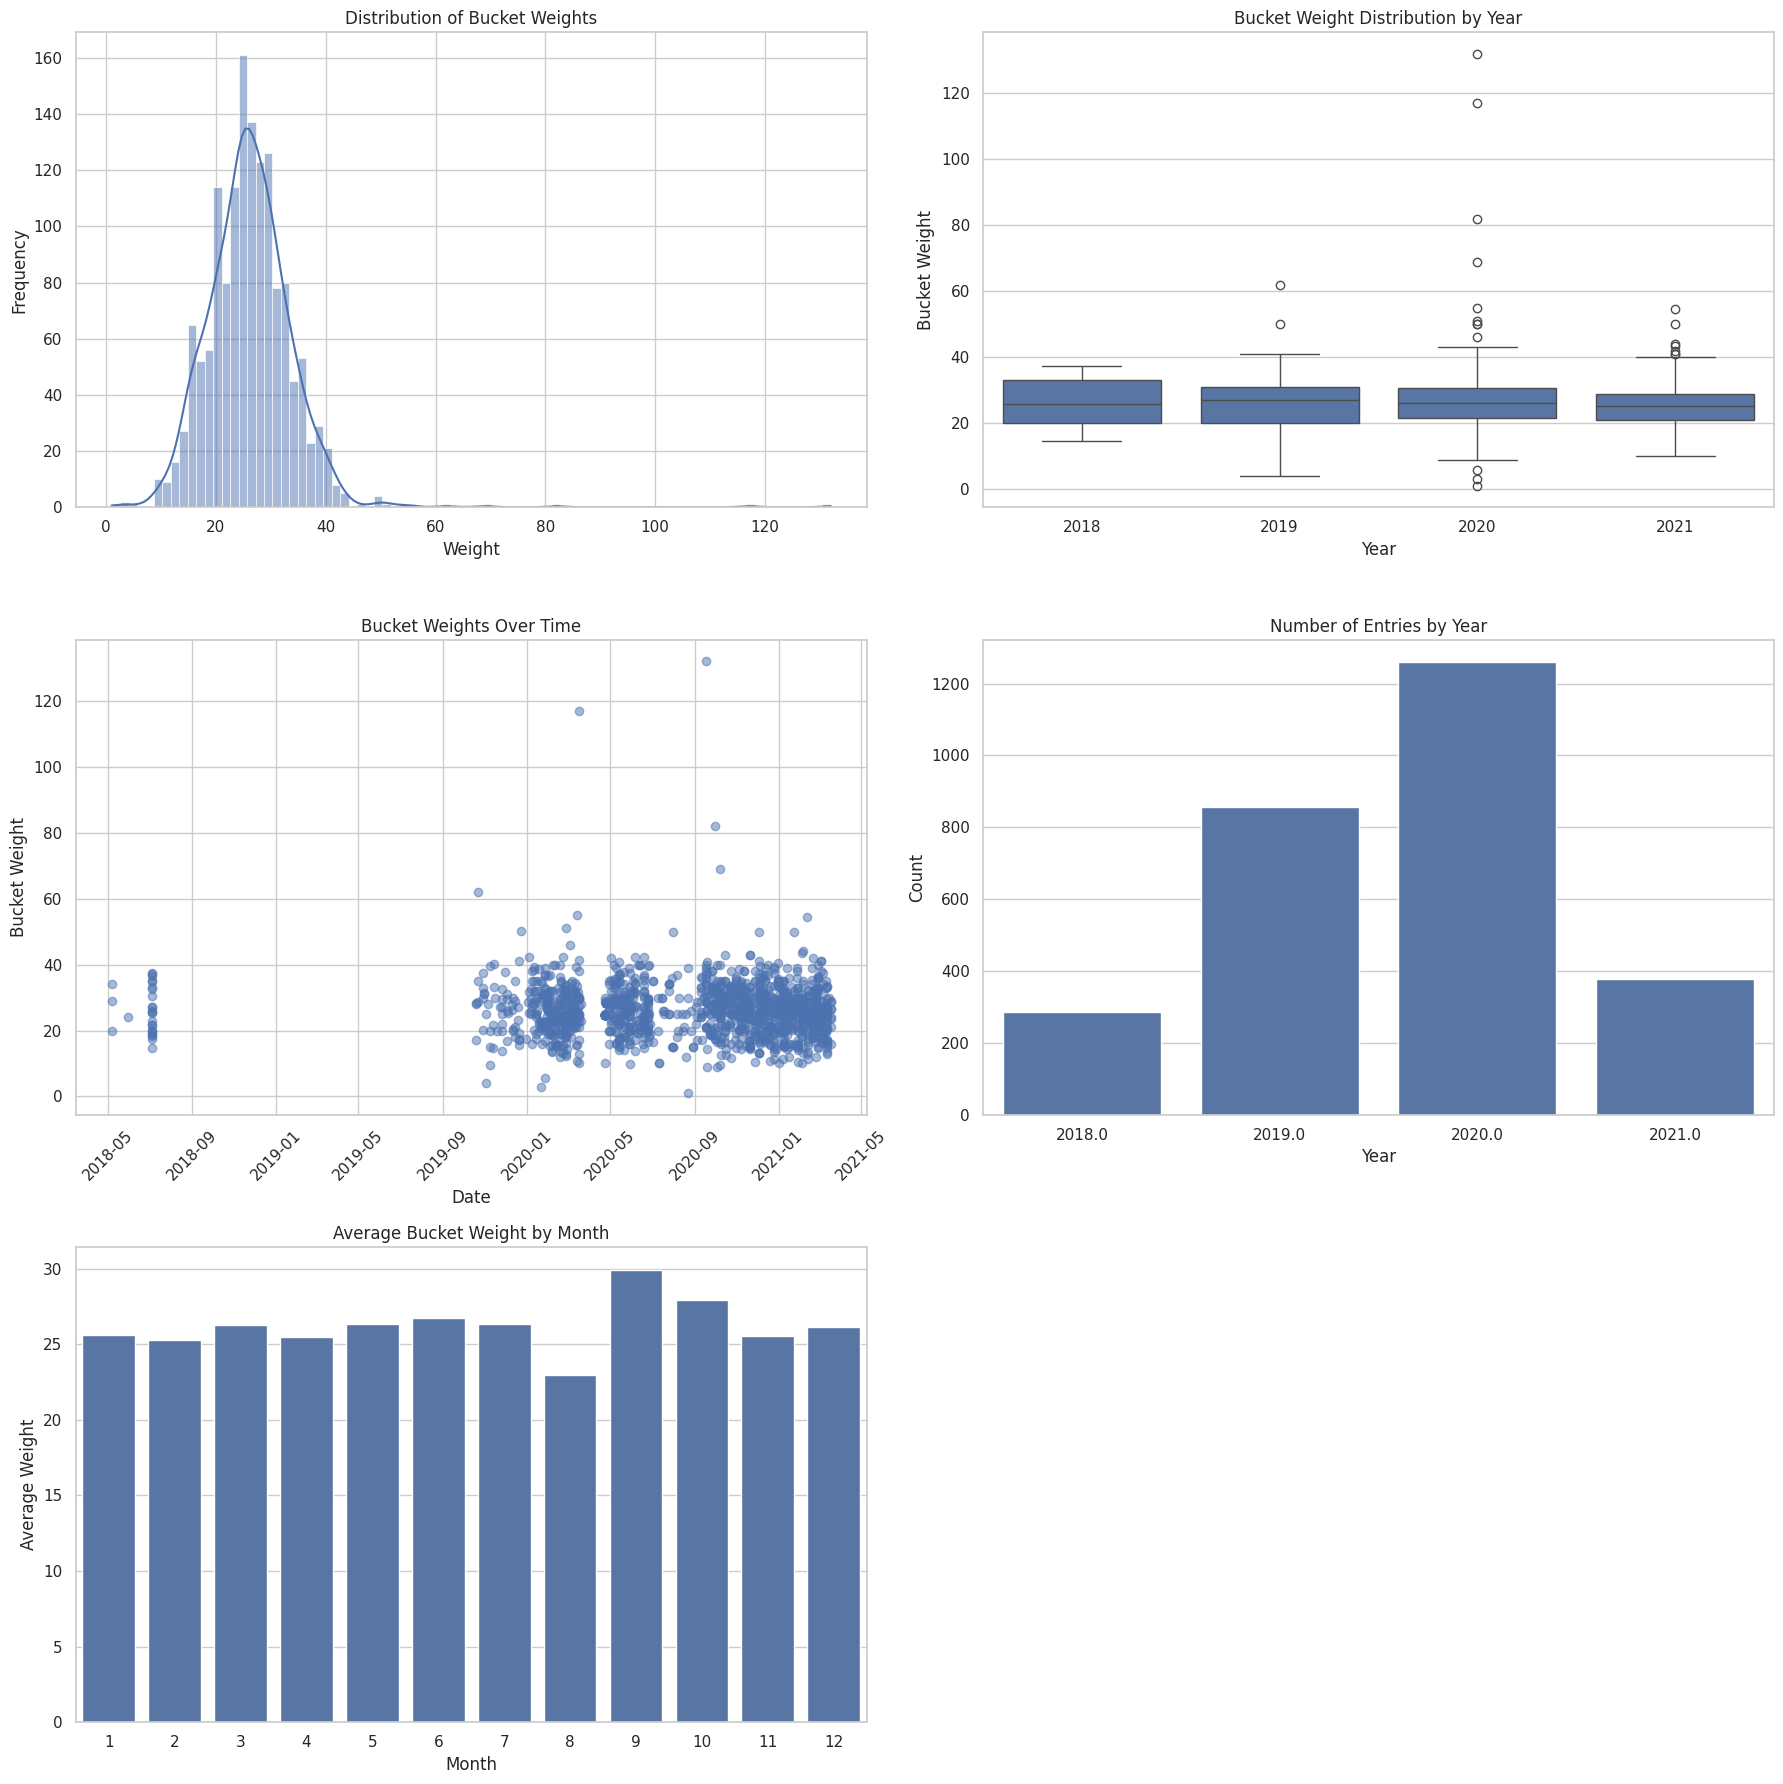

In [ ]:
plt.figure(figsize=(18, 18))  # Adjust the size as needed

# 1. Distribution of bucket weights
plt.subplot(3, 2, 1)
sns.histplot(my_df['bucket_weight'].dropna(), kde=True)
plt.title('Distribution of Bucket Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# 2. Box plot of bucket weights by year
plt.subplot(3, 2, 2)
sns.boxplot(x='year', y='bucket_weight', data=my_df)
plt.title('Bucket Weight Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Bucket Weight')

# 3. Bucket weights over time (sample points)
plt.subplot(3, 2, 3)
plt.scatter(my_df['date'], my_df['bucket_weight'], alpha=0.5)
plt.title('Bucket Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Bucket Weight')
plt.xticks(rotation=45)

# 4. Count of entries by year
plt.subplot(3, 2, 4)
yearly_counts = my_df.groupby(my_df['date'].dt.year).size()
sns.barplot(x=yearly_counts.index, y=yearly_counts.values)
plt.title('Number of Entries by Year')
plt.xlabel('Year')
plt.ylabel('Count')

# 5. Average bucket weight by month (across all years)
plt.subplot(3, 2, 5)
monthly_avg = my_df.groupby(my_df['date'].dt.month)['bucket_weight'].mean().reindex(range(1, 13))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Bucket Weight by Month')
plt.xlabel('Month')
plt.ylabel('Average Weight')

plt.tight_layout()
plt.show()

In [ ]:
#imputed with random values
#Imputed with multinomial from the middle 95% of data
import numpy as np
col = 'bucket_weight'
np.random.seed(42)

# def not_outlier(n):
#   lower = np.quantile(random_df[col], 0.025)
#   upper = np.quantile(random_df[col], 0.925)
#   return n>=lower and n<= upper
def random_impute(df, column):
    df = df.copy()

    # Extract non-missing values
    non_missing_values = df[column].dropna().values

    # Compute quantile bounds (for mild outlier exclusion)
    lower = np.quantile(non_missing_values, 0.025)
    upper = np.quantile(non_missing_values, 0.975)
    print("Lower:", lower)
    print("Upper:", upper)

    # Filter values within bounds
    filtered_values = [val for val in non_missing_values if lower <= val <= upper]

    # Frequency distribution of filtered values
    unique_vals, counts = np.unique(filtered_values, return_counts=True)
    probs = counts / counts.sum()

    # How many missing values to impute
    n_missing = df[column].isnull().sum()

    # Draw samples using multinomial distribution
    draw_counts = np.random.multinomial(n_missing, probs)
    imputed_values = []
    for val, count in zip(unique_vals, draw_counts):
        imputed_values.extend([val] * count)

    # Shuffle imputed values for randomness
    np.random.shuffle(imputed_values)

    # Replace NaNs with imputed values
    null_indices = df[df[column].isnull()].index
    for idx, val in zip(null_indices, imputed_values):
        df.at[idx, column] = val

    return df
random_df = my_df.copy()
random_impute(random_df, col)


Lower: 13.2
Upper: 40.0


,pp_num,month,day,year,last_name,correct_last_name,num_buckets,more_bb_needed,bucket_weight,date
0,47,3,12,2020,Roth-Heater,Roth-Heater,1,0.0,21.2,2020-03-12
1,112,3,12,2020,Evans,Evans,1,1.0,25.9,2020-03-12
2,147,3,12,2020,Bourgeot,Bourgeot,1,0.0,39.4,2020-03-12
3,152,3,12,2020,Grauer,Grauer,1,1.0,30.0,2020-03-12
4,54,3,12,2020,Ruiz,Ruiz,1,0.0,31.0,2020-03-12
...,...,...,...,...,...,...,...,...,...,...
2877,empty,7,4,2018,Anonymous,Anonymous,1,NaN,34.9,2018-07-04
2878,empty,7,4,2018,Anonymous,Anonymous,1,NaN,21.6,2018-07-04
2879,empty,7,4,2018,Anonymous,Anonymous,1,NaN,25.2,2018-07-04
2880,empty,7,4,2018,Anonymous,Anonymous,1,NaN,25.7,2018-07-04


8.106202709899058


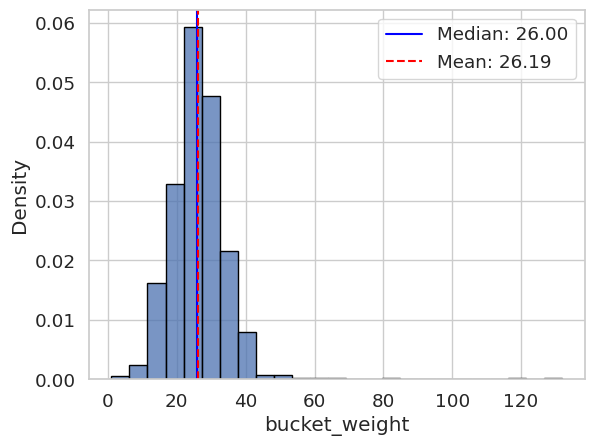

In [ ]:
sns.histplot(random_df[col], bins=25, kde=False, edgecolor='black', stat = 'density')

mean_val = random_df[col].mean()
median_val = random_df[col].median()

plt.axvline(median_val, color='blue', linestyle='-', label=f'Median: {median_val:.2f}')
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')

plt.legend()
print(random_df[col].std())

In [ ]:
my_df_notanon = my_df[~my_df['correct_last_name'].isin(['Anonymous'])]
my_df_notanon = my_df_notanon.dropna()

my_df_notanon = my_df_notanon[~my_df_notanon['date'].isna()]
my_df_notanon['date_ordinal'] = my_df_notanon['date'].map(pd.Timestamp.toordinal)
my_df_notanon[my_df_notanon['pp_num'] == '120']

# Remove -1 and 1 because there's only two rows, which leads to inaccurate correlation

slopes = {}
for num in my_df_notanon['pp_num'].unique():
  temp_df = my_df_notanon[my_df_notanon['pp_num'] == num]
  slope = temp_df['bucket_weight'].corr(temp_df['date_ordinal'])
  slopes[num] = slope

slopes_vals = pd.Series(slopes.values())
slopes_vals = slopes_vals.dropna()
slopes_vals = slopes_vals[slopes_vals != 1]
slopes_vals = slopes_vals[slopes_vals != -1]
slopes_vals

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


,0
0,0.675777
1,-0.443175
2,-0.422715
6,0.828494
7,-0.461507
...,...
132,-0.341866
133,1.000000
134,0.980691
135,-0.195082


In [ ]:
import fuzzy
from collections import defaultdict
from Levenshtein import distance

dmeta = fuzzy.DMetaphone()

# Frequency count
name_counts = my_df['last_name'].value_counts().to_dict()
unique_names = list(name_counts.keys())

# Build phonetic clusters with spelling similarity
name_map = {}
processed = set()

for name in unique_names:
    if name in processed:
        continue

    code = dmeta(name)[0]
    if code is None:
        continue

    cluster = []
    for other in unique_names:
        if other in processed or other == name:
            continue
        code_other = dmeta(other)[0]
        if code_other == code:
            lev_dist = distance(name.lower(), other.lower())
            # Only cluster if very similar in spelling
            if lev_dist <= 2:
                cluster.append(other)

    # Always include the original name
    cluster.append(name)

    # Choose the most frequent as the correct name
    correct_name = max(cluster, key=lambda x: name_counts.get(x, 0))
    for n in cluster:
        name_map[n] = correct_name
        processed.add(n)

# Apply mapping
my_df['last_name_corrected'] = my_df['last_name'].map(name_map)

In [ ]:
my_df = my_df.drop(columns = ['correct_last_name'])

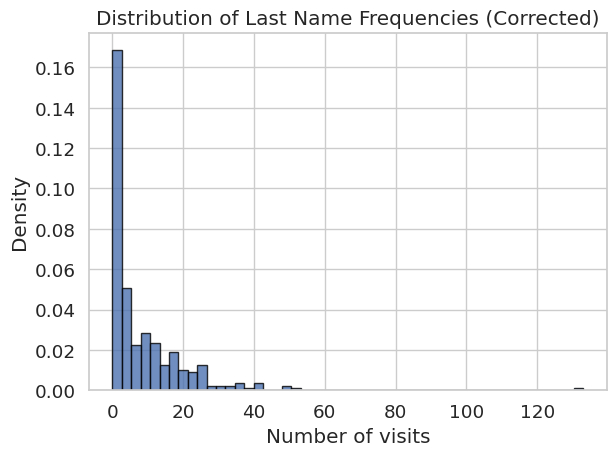

In [ ]:
my_df.groupby('last_name_corrected')['month'].count().hist(
    bins=50,
    density=True,
    edgecolor='black',
    alpha=0.8
)

plt.title('Distribution of Last Name Frequencies (Corrected)')
plt.xlabel('Number of visits')
plt.ylabel('Density')
plt.tight_layout()
plt.show()